# Imports

In [1]:
import optuna

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import cdist

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# X, y = make_blobs(n_samples=1000, n_features=10, shuffle=True, random_state=42, cluster_std=2.0, centers=5)
X = pd.read_csv("../data/mallcustomers.csv").drop(columns=["CustomerID"]).rename(columns={"Annual Income (k$)": "annual_income", "Spending Score (1-100)": "spending_score"})
X.columns = [c.lower() for c in X.columns]

X.loc[X['gender'] == 'Male', 'gender'] = 1
X.loc[X['gender'] == 'Female', 'gender'] = 0

In [3]:
X.shape

(200, 4)

In [4]:
ss = StandardScaler()
X_ss = pd.DataFrame(ss.fit_transform(X), columns=[f'{c}_ss' for c in X.columns], index=X.index)

In [5]:
def get_kmeans_params(trial, random_state=42):
    
    return {
        'n_clusters': trial.suggest_int('n_clusters', 2, 10),
        'n_init': trial.suggest_int('n_init', 5, 20),
        'random_state': trial.suggest_categorical('random_state', [random_state])
    }

def get_umap_params(trial, random_state=42):

    return {
        'n_components': trial.suggest_int('n_components', 2, 10),  
        'n_neighbors': trial.suggest_int('n_neighbors', 5, 100),  
        'min_dist': trial.suggest_float('min_dist', 0.01, 0.99)
    }

def get_pca_params(trial, X: pd.DataFrame, random_state=42):

    return {
        'n_components': trial.suggest_int('n_components', 2, X.shape[1]),
        'random_state': trial.suggest_categorical('random_state', [random_state])
    }

def get_cluster_metrics(X: pd.DataFrame, y: pd.Series) -> dict[str, float]:
    
    return {
        'Silhouetete': silhouette_score(X, y),
        'Davies Bouldin': davies_bouldin_score(X, y),
        'Calinski Harabasz': calinski_harabasz_score(X, y)
    }

def plot_clusters(X: pd.DataFrame, y: pd.Series, model_name: str) -> None:
    
    if X.shape[1] > 5:
        print("X has more than 5 features, selecting the first 5 for visualization.")
        X = X.iloc[:, :5]

    df = pd.concat([X, y], axis=1)

    plt.figure(figsize=(10, 6))
    sns.pairplot(data=df, hue=model_name)
    plt.show()

def plot_cluster_distribution(y: pd.Series, model_name: str) -> None:
    
    counts = pd.Series(y).value_counts().sort_index()
    
    plt.figure(figsize=(10, 4))
    bars = plt.bar(counts.index.astype(str), counts.values)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2., 
            height,
            f'{int(height)}', ha='center', va='bottom'
        )
    
    plt.title(f"Distribuição de Clusters - {model_name}\nTotal clusters: {len(counts)}")
    plt.xlabel("Cluster ID")
    plt.ylabel("Número de Pontos")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

def plot_cluster_density(X, y, bandwidth=0.5):
    
    plt.figure(figsize=(10, 6))
    
    for cluster in np.unique(y):
        kde = KernelDensity(bandwidth=bandwidth).fit(X[y == cluster])
        scores = kde.score_samples(X[y == cluster])
        plt.hist(scores, bins=30, alpha=0.5, label=f'Cluster {cluster}')
    
    plt.xlabel('Log-Densidade')
    plt.ylabel('Frequência')
    plt.title('Distribuição de Densidade por Cluster')
    plt.legend()
    plt.show()

def plot_silhouette_analysis(X, y, model_name):
    
    silhouette_vals = silhouette_samples(X, y)
    cluster_labels = np.unique(y)
    n_clusters = len(cluster_labels)
    
    plt.figure(figsize=(10, 6))
    y_lower = 10
    
    for i in cluster_labels:
        ith_cluster_silhouette = silhouette_vals[y == i]
        ith_cluster_silhouette.sort()
        
        size_cluster_i = ith_cluster_silhouette.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, ith_cluster_silhouette,
            facecolor=color, edgecolor=color, alpha=0.7
        )
        
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.title(f"Silhouette Plot - {model_name}\nAvg Score: {silhouette_avg:.2f}")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster Label")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([])
    plt.show()

def plot_cluster_centroid_distances(X: pd.DataFrame, y: pd.Series) -> None:
    
    centroids = pd.DataFrame(X).groupby(y).mean()
    distances = cdist(centroids, centroids)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(distances, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Distance between Cluster Centers")
    plt.xlabel("Cluster")
    plt.ylabel("Cluster")
    plt.show()

def plot_feature_importance_by_cluster(X: pd.DataFrame, y: pd.Series, top_n: int = 10) -> None:
    
    importances = []

    for cluster in np.unique(y):
        mean_diff = X[y == cluster].mean() - X.mean()
        importance = mean_diff.abs().sort_values(ascending=False).head(top_n)
        importances.append(importance)

    df_importance = pd.concat(importances, axis=1)
    df_importance.columns = [f"Cluster {i}" for i in np.unique(y)]

    df_importance.plot(kind='barh', figsize=(10, 6))
    plt.title("Top Features by Cluster")
    plt.xlabel("Mean Absolute Difference")
    plt.grid(True, axis='x')
    plt.show()

def get_results(X: pd.DataFrame, y: pd.Series, model_name: str) -> None:

    plot_clusters(X, y[model_name], model_name)
    plot_silhouette_analysis(X, y[model_name], model_name)
    plot_feature_importance_by_cluster(X, y[model_name])
    plot_cluster_centroid_distances(X, y[model_name])
    plot_cluster_distribution(y[model_name], model_name)
    plot_cluster_density(X, y[model_name])

In [6]:
class AutoMLKMeans:

    def __init__(self, X, n_trials=100, random_state=42):
        
        self.X = X
        self.n_trials = n_trials
        self.y = pd.DataFrame()
        self.random_state = random_state

    def _get_best_params(self) -> dict:

        def objective(trail):

            kmeans_params = get_kmeans_params(trail, self.random_state)

            kmeans = KMeans(**kmeans_params)
            kmeans.fit(self.X)

            y_pred = kmeans.predict(self.X)

            return silhouette_score(self.X, y_pred)
        
        optuna.logging.set_verbosity(optuna.logging.WARNING)

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=self.n_trials)
        
        return study.best_params
    
    def _get_best_pca_kmeans_params(self) -> dict:

        def objective(trail):

            kmeans_params = get_kmeans_params(trail, self.random_state)

            pca_params = get_pca_params(trail, self.X, self.random_state)

            reducer = PCA(**pca_params)
            X_reduced = reducer.fit_transform(self.X)

            kmeans = KMeans(**kmeans_params)
            kmeans.fit(X_reduced)

            y_pred = kmeans.predict(X_reduced)

            return silhouette_score(X_reduced, y_pred)
        
        optuna.logging.set_verbosity(optuna.logging.WARNING)

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=self.n_trials)
        
        return study.best_params
    
    def _get_best_umap_kmeans_params(self) -> dict:

        def objective(trail):

            kmeans_params = get_kmeans_params(trail, self.random_state)

            umap_params = get_umap_params(trail)

            reducer = UMAP(**umap_params)
            X_reduced = reducer.fit_transform(self.X)

            kmeans = KMeans(**kmeans_params)
            kmeans.fit(X_reduced)

            y_pred = kmeans.predict(X_reduced)

            return silhouette_score(X_reduced, y_pred)
        
        optuna.logging.set_verbosity(optuna.logging.WARNING)

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=self.n_trials)
        
        return study.best_params

    def _train_base_model(self) -> tuple:

        best_params = self._get_best_params()
        
        self.base_model = KMeans(**best_params)
        self.base_model.fit(self.X)

        self.y['base_model'] = self.base_model.predict(self.X)
    
        return get_cluster_metrics(self.X, self.y['base_model'])
    
    def _train_pca_kmeans_model(self) -> tuple:

        best_params = self._get_best_pca_kmeans_params()

        self.pca = PCA(
            n_components=best_params['n_components'], 
            random_state=best_params['random_state']
        )
        
        X_reduced = self.pca.fit_transform(self.X)

        self.X_pca = pd.DataFrame(X_reduced, columns=[f"pca_{i}" for i in range(X_reduced.shape[1])])
        
        self.pca_kmeans_model = KMeans(
            n_clusters=best_params['n_clusters'], 
            n_init=best_params['n_init'], 
            random_state=best_params['random_state']
        )   
        
        self.y['pca_kmeans_model'] = self.pca_kmeans_model.fit_predict(self.X_pca)

        return get_cluster_metrics(self.X_pca, self.y['pca_kmeans_model'])
    
    def _train_umap_kmeans_model(self) -> tuple:

        best_params = self._get_best_umap_kmeans_params()

        self.umap = UMAP(
            n_components=best_params['n_components'],  
            n_neighbors=best_params['n_neighbors'],  
            min_dist=best_params['min_dist']  
        )
        
        X_reduced = self.umap.fit_transform(self.X)

        self.X_umap = pd.DataFrame(X_reduced, columns=[f"umap_{i}" for i in range(X_reduced.shape[1])])
        
        self.umap_kmeans_model = KMeans(
            n_clusters=best_params['n_clusters'], 
            n_init=best_params['n_init'], 
            random_state=best_params['random_state']
        )
        
        self.y['umap_kmeans_model'] = self.umap_kmeans_model.fit_predict(self.X_umap)

        return get_cluster_metrics(self.X_umap, self.y['umap_kmeans_model'])

    def train(self) -> None:

        self.result_train_base_model = self._train_base_model()
        self.result_pca_kmeans_model = self._train_pca_kmeans_model()
        self.result_umap_kmeans_model = self._train_umap_kmeans_model()

    def get_metrics(self) -> dict:

        return pd.DataFrame(
            {
                "Base KMeans Model": self.result_train_base_model,
                "PCA KMeans Model": self.result_pca_kmeans_model,
                "UMAP KMeans Model": self.result_umap_kmeans_model
            }
        )
    
    def get_model_results(self) -> None:

        results = self.get_metrics()

        print("Base KMeans Model")
        display(results["Base KMeans Model"])
        get_results(self.X, self.y, "base_model")

        print("PCA KMeans Model")
        display(results["PCA KMeans Model"])
        get_results(self.X_pca, self.y, "pca_kmeans_model")
        
        print("UMAP KMeans Model")
        display(results["UMAP KMeans Model"])
        get_results(self.X_umap, self.y, "umap_kmeans_model")

In [7]:
a = AutoMLKMeans(X_ss, n_trials=100)

In [8]:
a.train()

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-pack

In [9]:
a.get_metrics()

,Base KMeans Model,PCA KMeans Model,UMAP KMeans Model
Silhouetete,0.420764,0.426940,0.879315
Davies Bouldin,0.833103,0.762146,0.144196
Calinski Harabasz,89.978196,116.938545,4132.519043


Base KMeans Model


Silhouetete           0.420764
Davies Bouldin        0.833103
Calinski Harabasz    89.978196
Name: Base KMeans Model, dtype: float64

<Figure size 1000x600 with 0 Axes>

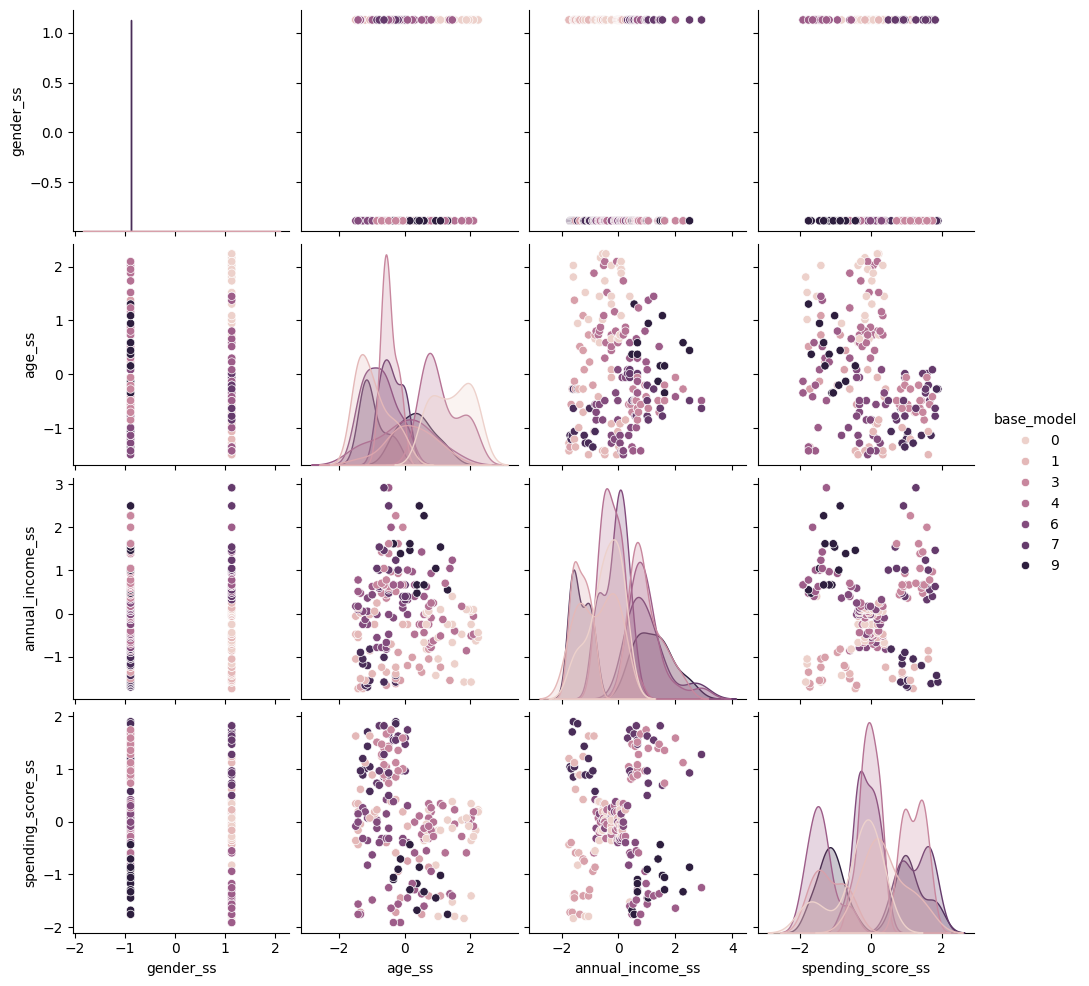

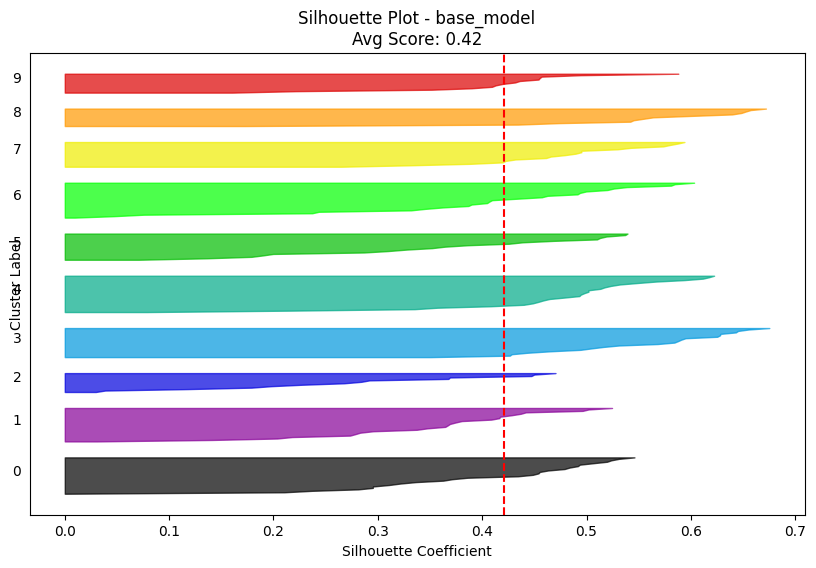

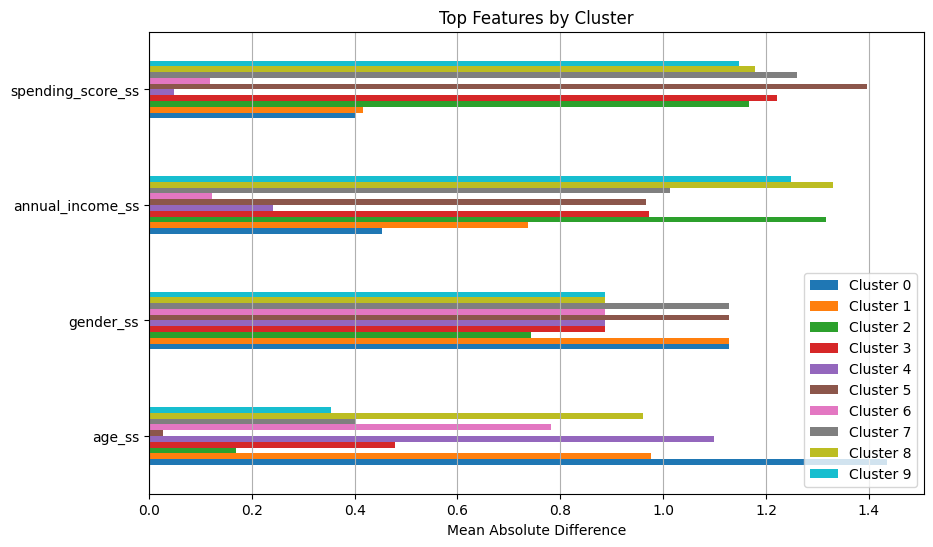

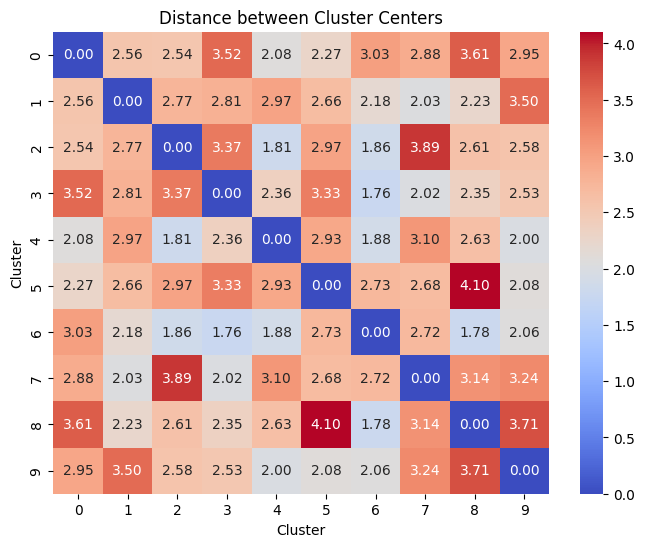

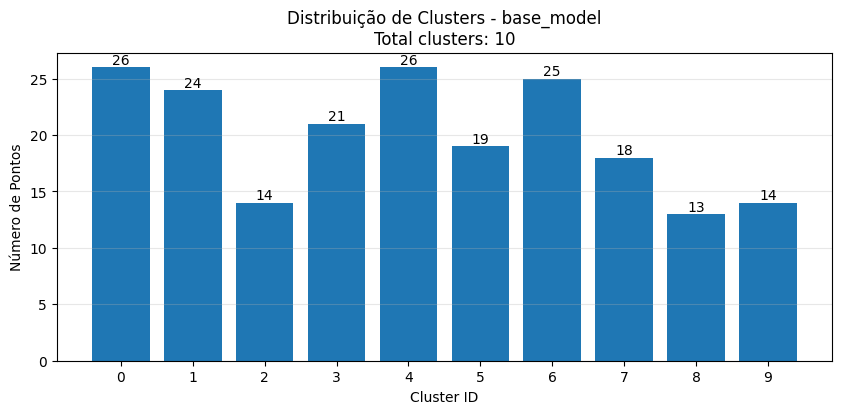

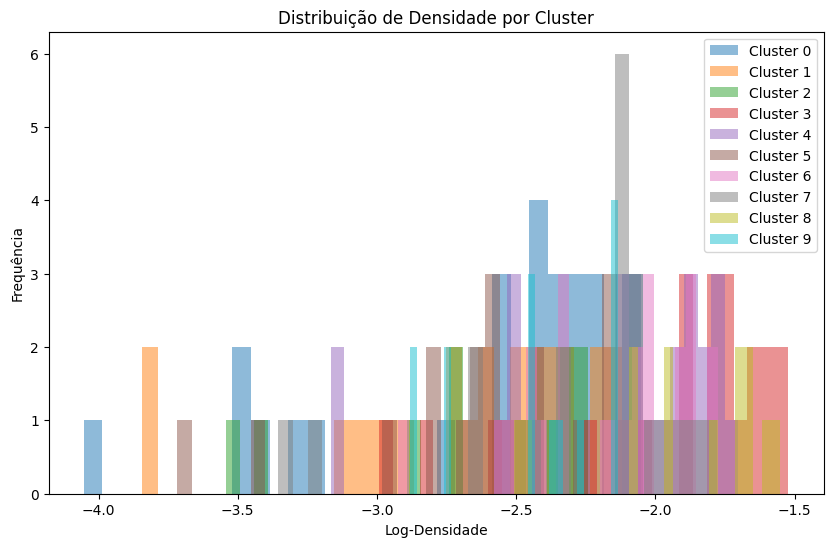

PCA KMeans Model


Silhouetete            0.426940
Davies Bouldin         0.762146
Calinski Harabasz    116.938545
Name: PCA KMeans Model, dtype: float64

<Figure size 1000x600 with 0 Axes>

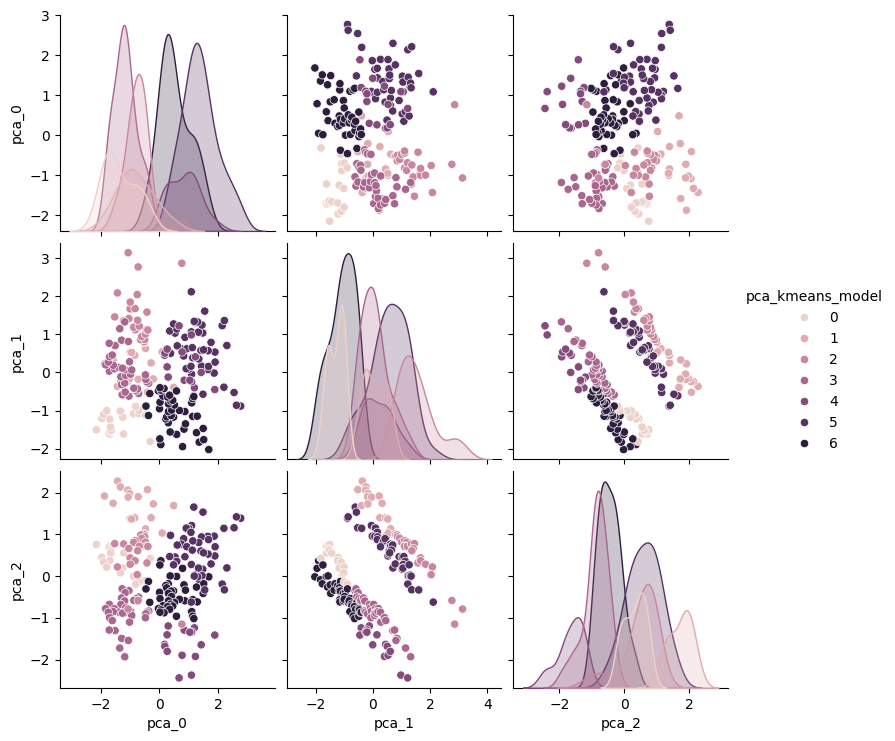

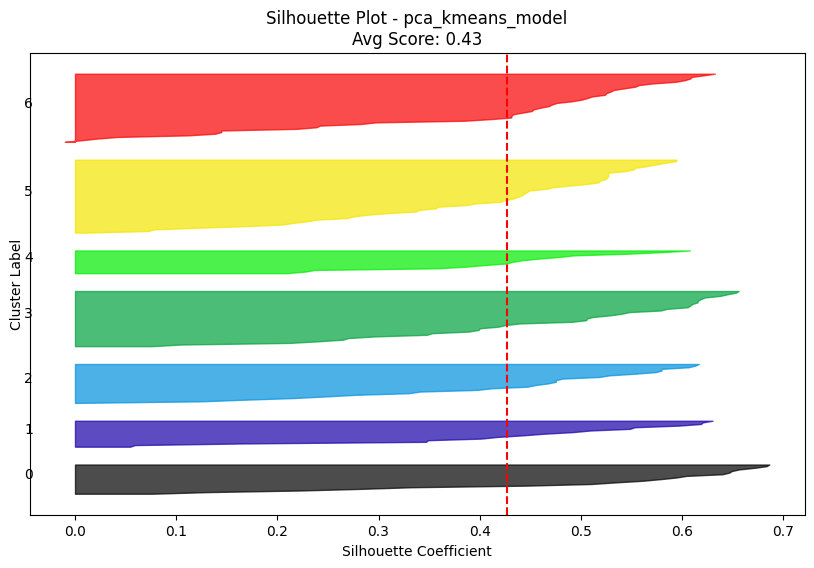

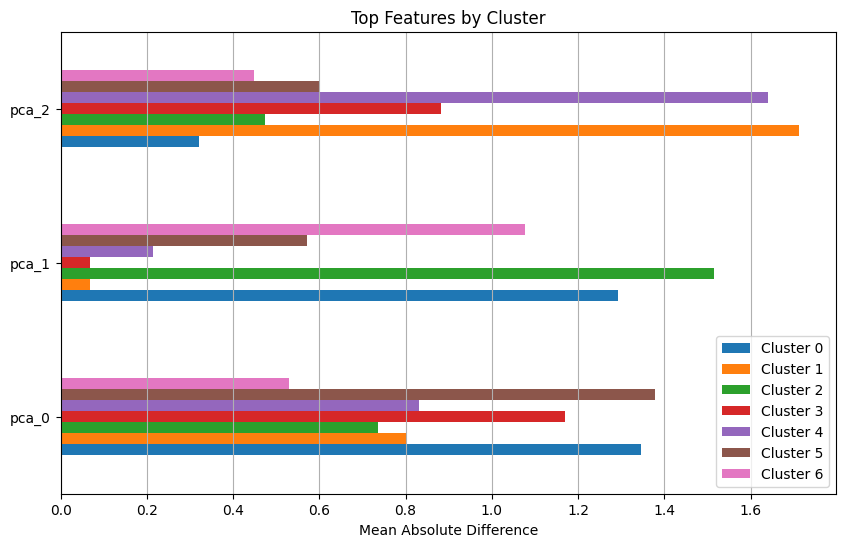

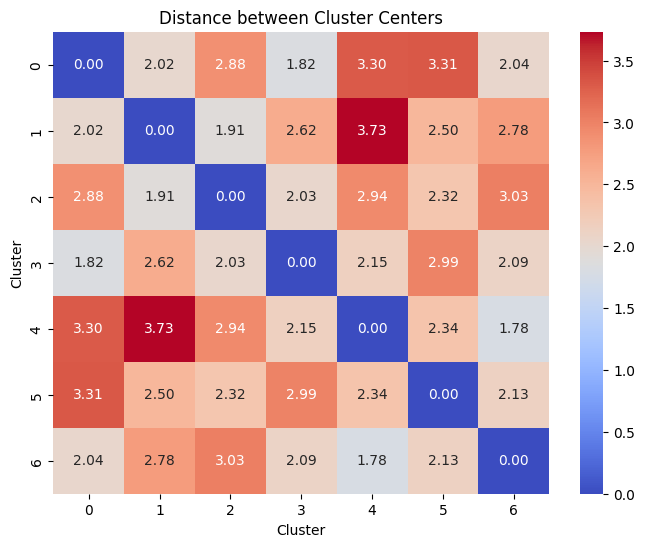

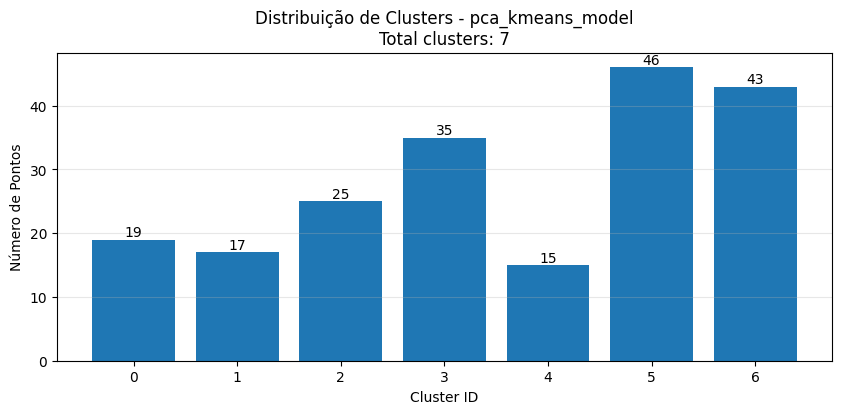

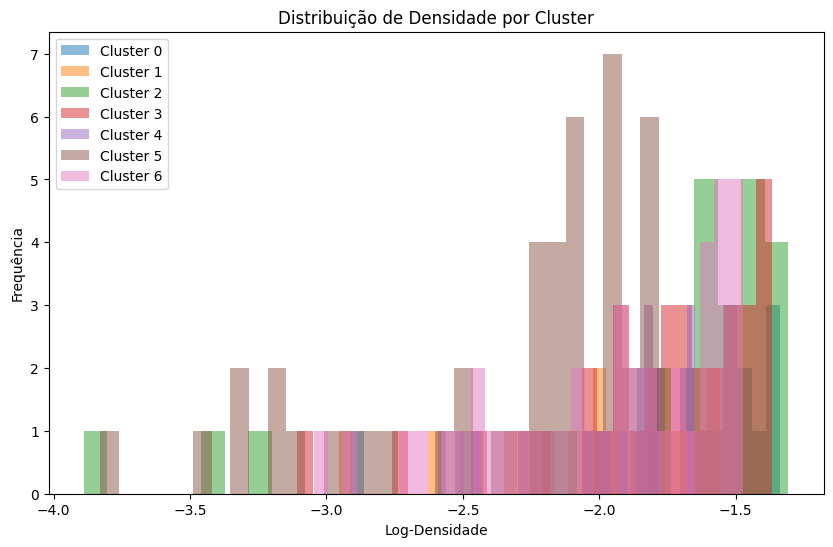

UMAP KMeans Model


Silhouetete             0.879315
Davies Bouldin          0.144196
Calinski Harabasz    4132.519043
Name: UMAP KMeans Model, dtype: float64

<Figure size 1000x600 with 0 Axes>

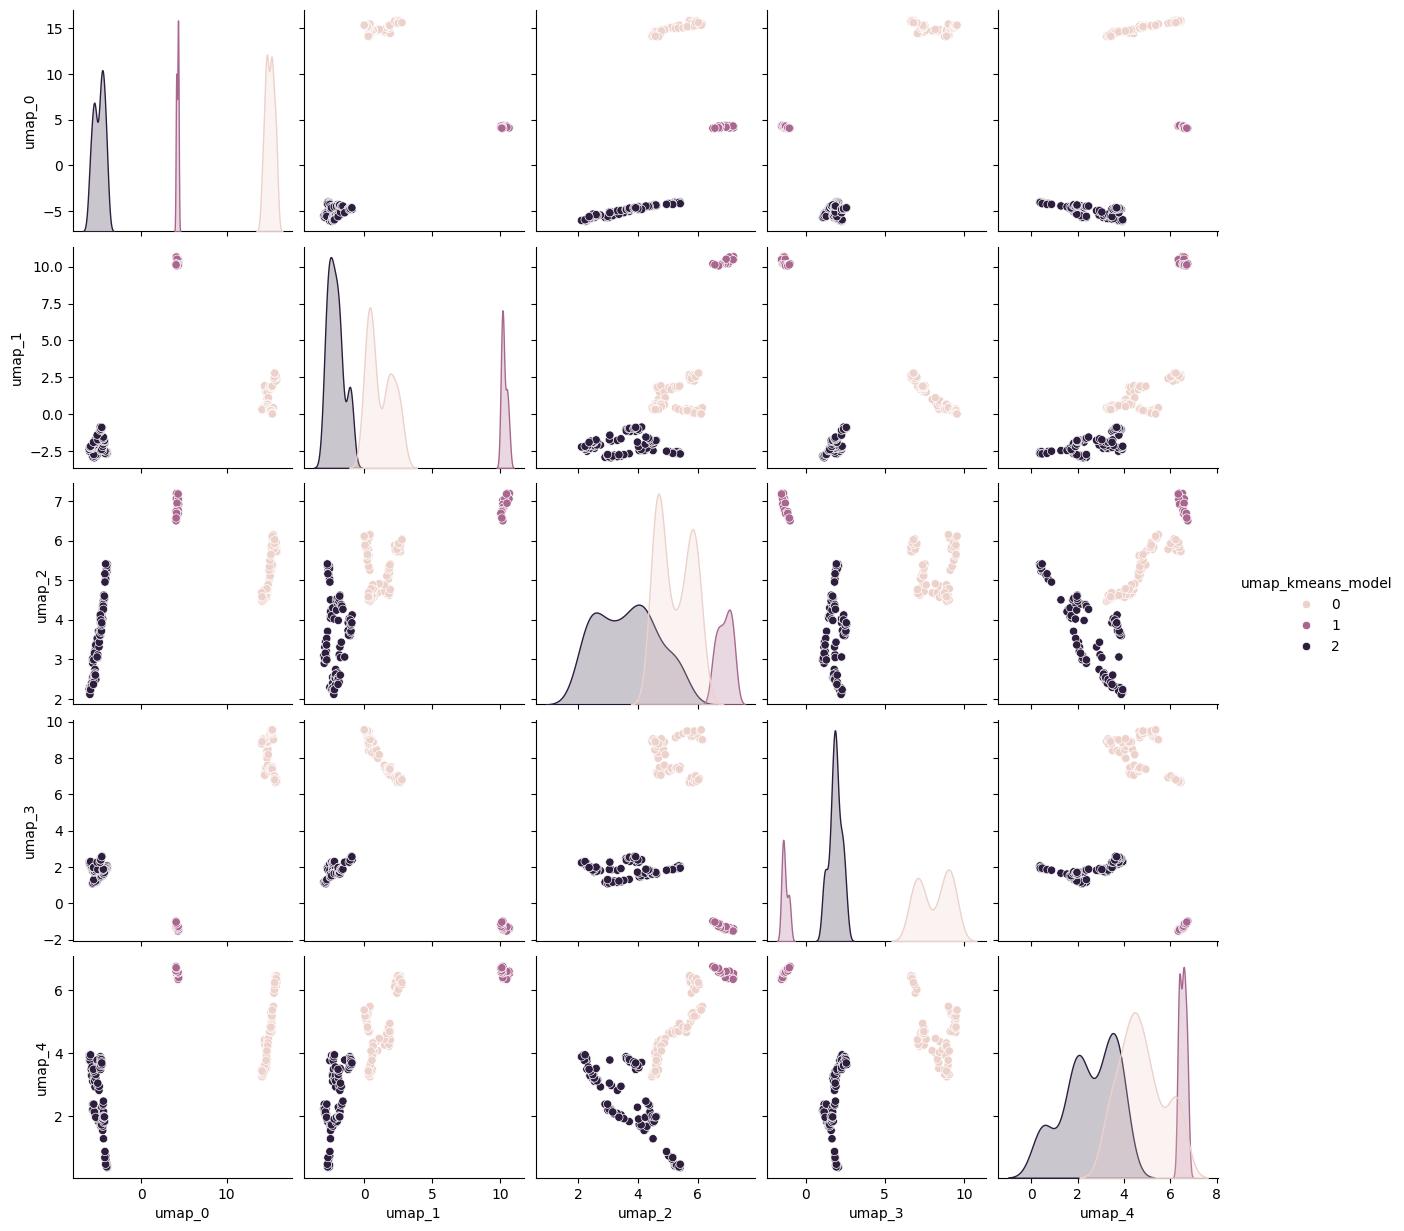

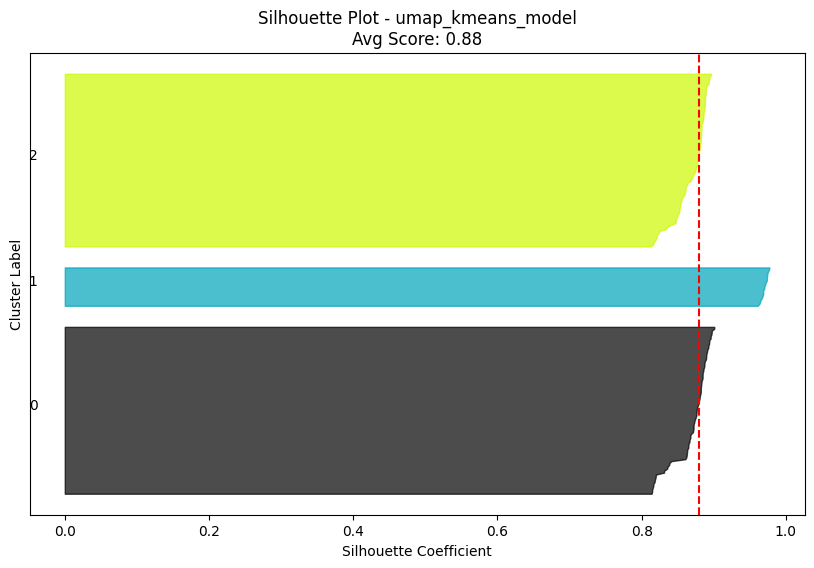

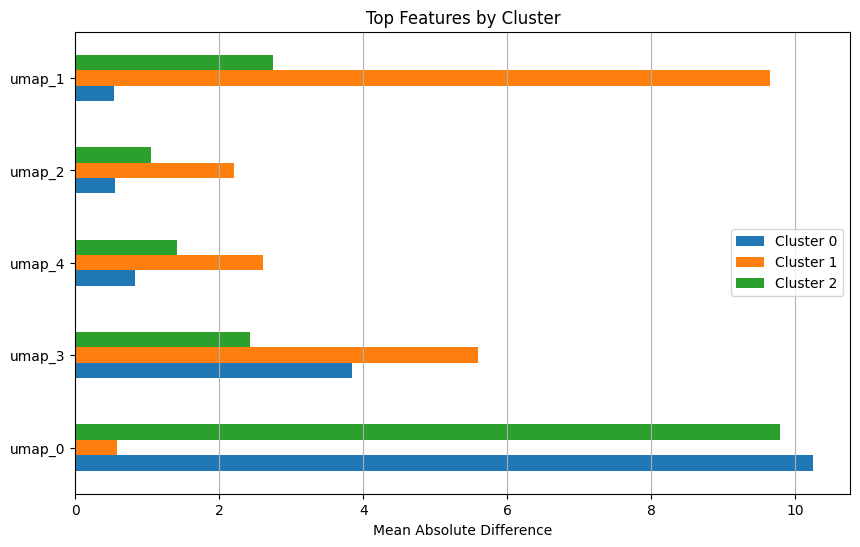

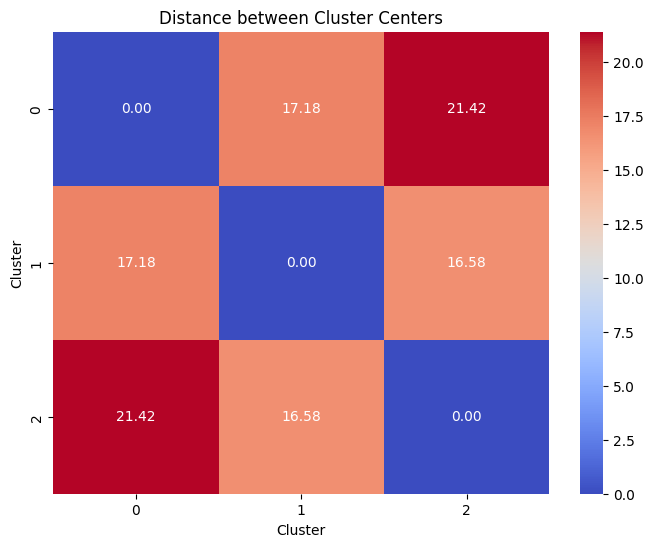

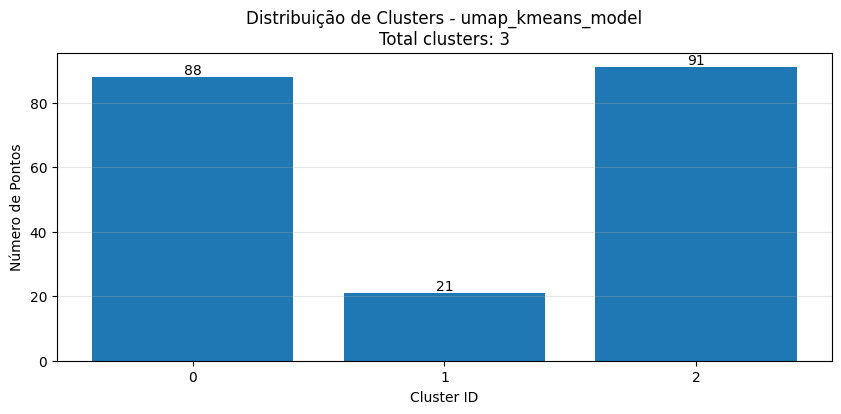

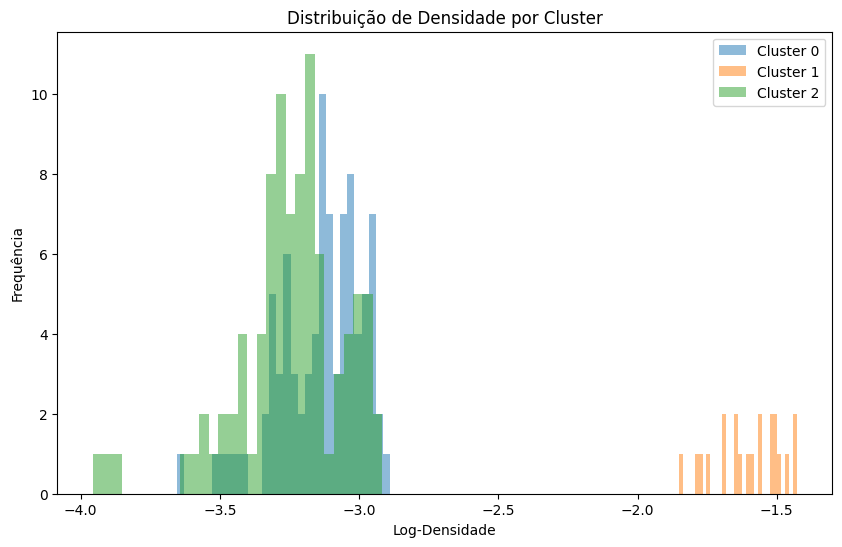

In [10]:
a.get_model_results()